In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Dict, Tuple


In [3]:
df = pd.read_csv('../../Datasets/Final Datasets/model_dataset.csv')
df.head()

,O*NET-SOC Code,Title,Attribute Type,Element ID,Element Name,Scale Name,Data Value
0,11-1011.00,Chief Executives,Knowledge,2.C.1.a,Administration and Management,Importance,4.78
1,11-1011.00,Chief Executives,Knowledge,2.C.1.a,Administration and Management,Level,6.50
2,11-1011.00,Chief Executives,Knowledge,2.C.1.b,Administrative,Importance,2.42
3,11-1011.00,Chief Executives,Knowledge,2.C.1.b,Administrative,Level,2.69
4,11-1011.00,Chief Executives,Knowledge,2.C.1.c,Economics and Accounting,Importance,4.04


In [4]:
df.info()

df.describe()

df.isnull().sum()

df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391425 entries, 0 to 391424
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   O*NET-SOC Code  391425 non-null  object 
 1   Title           391425 non-null  object 
 2   Attribute Type  391425 non-null  object 
 3   Element ID      391425 non-null  object 
 4   Element Name    391425 non-null  object 
 5   Scale Name      391425 non-null  object 
 6   Data Value      391425 non-null  float64
dtypes: float64(1), object(6)
memory usage: 20.9+ MB


Index(['O*NET-SOC Code', 'Title', 'Attribute Type', 'Element ID',
       'Element Name', 'Scale Name', 'Data Value'],
      dtype='object')

## Input Issue

The issue is that we have over 390,000 samples. Meaning if we want user to give inputs to get recommendations, they need to give inputs for over 390,000 features. This is not feasible and user-friendly. Some technical solutions to this problem are:

1. Use dimensionality reduction techniques like PCA to reduce the number of features.
2. Use clustering techniques to group similar samples together. 

But the thing is for dimensionality reduction (PCA) approach is that we create new features based on the relevancy of variance. But we only have 7 features and we need to use all of them. Issue is the number of inputs needed under each 'Attribute Type'. For example, for our first attribute type 'Knowledge' alone, there are multiple elements required to be inputted like 'Administration and Management', 'Administrative', 'Economics and Accounting', etc. These are all rows in our dataset rather than columns(features).

So we need to find a way to reduce the number of inputs needed from the user while still maintaining the relevance of the features. So a more user-friendly approach would be to use clustering techniques.

### Hierarchical Clustering Approach:

**Advantages:**
- Maintains intpretability of attributes.
- Can cluster similar elements together within each attribute type.
- More intuitive for users to understand.

**Disadvantages:**
- Doesn't reduce input complexity as effectively.
- Still requires user to input a lot of features.
- May lose granularity in recommendations.

In [5]:
df['Attribute Type'].unique()

array(['Knowledge', 'Skill', 'Ability', 'Education', 'Experience',
       'Training', 'Interest', 'Work Values', 'Work Styles',
       'Work Activity', 'Work Context'], dtype=object)

In [6]:
# Attributes worth clustering are: ['Knowledge', 'Skill', 'Ability', 'Work Context', 'Work Activity']
# Dropping 'Level' as one of the scales and only using 'Importance'. A bit redundant... but I do need to keep 'Context' scale for 'Work Context' attribute type.
attributes = ['Knowledge', 'Skill', 'Ability', 'Work Context', 'Work Activity']
attributes_df = df[(df['Attribute Type'].isin(attributes)) & (df['Scale Name'] == 'Importance') | (df['Scale Name'] == 'Context')].copy() #Making a copy, not a view
attributes_df['Attribute Type'].unique()

array(['Knowledge', 'Skill', 'Ability', 'Work Activity', 'Work Context'],
      dtype=object)

In [7]:
# Since we only are using one scale = 'Importance' we don't need 'Scale Name' column, because we know 'Data Value' column is just 'Importance'
attributes_df.drop('Scale Name', axis=1, inplace=True)
attributes_df.drop('O*NET-SOC Code', axis=1, inplace=True)
attributes_df.drop('Element ID', axis=1, inplace=True)
attributes_df.rename(columns={'Element Name': 'Attribute Element'}, inplace=True)
attributes_df.reset_index(inplace=True)


In [8]:
attributes_df.head()

,index,Title,Attribute Type,Attribute Element,Data Value
0,0,Chief Executives,Knowledge,Administration and Management,4.78
1,2,Chief Executives,Knowledge,Administrative,2.42
2,4,Chief Executives,Knowledge,Economics and Accounting,4.04
3,6,Chief Executives,Knowledge,Sales and Marketing,3.81
4,8,Chief Executives,Knowledge,Customer and Personal Service,4.39


In [9]:
attributes_df.drop('index', axis=1, inplace=True)
attributes_df.head()

,Title,Attribute Type,Attribute Element,Data Value
0,Chief Executives,Knowledge,Administration and Management,4.78
1,Chief Executives,Knowledge,Administrative,2.42
2,Chief Executives,Knowledge,Economics and Accounting,4.04
3,Chief Executives,Knowledge,Sales and Marketing,3.81
4,Chief Executives,Knowledge,Customer and Personal Service,4.39


### Wide Format Before Hierarchical Clustering

This format is specifically focusing on the 'Attribute Type' and 'Attribute Elements' columns. Where for each title, we have the importance of each attribute type and attribute elements. Our goal is the cluster the attribute elements together within each attribute type.

Might have to create a separate wide format for each attribute type. For each attribute:
- Perform clustering
- Validate clusters
- Create 'super categories' based on the clusters

This could reduce, for example:
- 35 Knowledge types → 5-7 knowledge clusters
- 50 Skills → 6-8 skill clusters

I think we should create a wide format for each attribute type because clustering and PCA expects feature vectors. So we can make something like this for Knowledge attribute type:

```
Title    Science   Math    Analysis
Doctor    4.8      3.2     4.5
Nurse     4.2      2.8     4.0
```

This is ideal for clustering and PCA, since we want each row to be one complete sample. In our case, each row being one job title and all the values being the importance of the attribute elements.

In [10]:
knowledge = attributes_df[attributes_df['Attribute Type'] == 'Knowledge']
skill = attributes_df[attributes_df['Attribute Type'] == 'Skill']
ability = attributes_df[attributes_df['Attribute Type'] == 'Ability']
work_context = attributes_df[attributes_df['Attribute Type'] == 'Work Context']
work_activity = attributes_df[attributes_df['Attribute Type'] == 'Work Activity']

# Wide Format for each attribute type
knowledge_wide = knowledge.pivot(index='Title',
                                columns='Attribute Element',
                                values='Data Value')
skill_wide = skill.pivot(index='Title',
                        columns='Attribute Element',
                        values='Data Value')
ability_wide = ability.pivot(index='Title',
                              columns='Attribute Element',
                              values='Data Value')
work_context_wide = work_context.pivot(index='Title',
                                      columns='Attribute Element',
                                      values='Data Value')
work_activity_wide = work_activity.pivot(index='Title',
                                        columns='Attribute Element',
                                        values='Data Value')

## Handling Missing Values, standardizing the data, and applying PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Dictionary of dataframes for each attribute type
dfs = {
    'Knowledge': knowledge_wide,
    'Skill': skill_wide,
    'Ability': ability_wide,
    'Work Context': work_context_wide,
    'Work Activity': work_activity_wide
}

# Empty dictionary to store preprocessed dataframes
preprocessed_dfs = {}

# Preprocess each dataframe with PCA
for attribute_type, df in dfs.items():
    # Calculate number of components to explain 95% of variance
    n_components = min(len(df.columns), len(df.index))
    
    preprocess = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95))  # Keep components explaining 95% of variance
    ])
    
    # Fit and transform the data
    transformed_data = preprocess.fit_transform(df)
    
    # Get feature names based on PCA components
    n_components_selected = transformed_data.shape[1]
    feature_names = [f'PC{i+1}' for i in range(n_components_selected)]
    
    # Create DataFrame with PCA results
    preprocessed_dfs[attribute_type] = pd.DataFrame(
        transformed_data,
        columns=feature_names,
        index=df.index
    )


In [11]:
# Checking size of each dataframe
print("Before PCA:")
print("Knowledge: ", knowledge_wide.shape)
print("Skill: ", skill_wide.shape)
print("Ability: ", ability_wide.shape)
print("Work Context: ", work_context_wide.shape)
print("Work Activity: ", work_activity_wide.shape)

print("\nAfter PCA:")
print("Knowledge: ", preprocessed_dfs['Knowledge'].shape)
print("Skill: ", preprocessed_dfs['Skill'].shape)
print("Ability: ", preprocessed_dfs['Ability'].shape)
print("Work Context: ", preprocessed_dfs['Work Context'].shape)
print("Work Activity: ", preprocessed_dfs['Work Activity'].shape)


Before PCA:
Knowledge:  (873, 33)
Skill:  (873, 35)
Ability:  (873, 52)
Work Context:  (873, 55)
Work Activity:  (873, 41)

After PCA:
Knowledge:  (873, 21)
Skill:  (873, 18)
Ability:  (873, 23)
Work Context:  (873, 32)
Work Activity:  (873, 26)


In [12]:
preprocessed_dfs['Knowledge'].head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
Title,,,,,,,,,,,,,,,,,,,,,
Accountants and Auditors,0.150844,-1.677329,-3.569633,-1.439588,-2.775247,-0.688476,2.091873,-1.999936,-0.105774,-0.369862,...,-0.700545,1.025221,0.472764,0.819258,0.315887,-0.450476,1.080194,-0.215655,-0.843256,0.359045
Actors,3.150748,-3.826821,-1.083192,4.491928,1.502716,3.698599,-1.631303,0.511189,-1.195583,-1.252292,...,-0.616948,0.417815,-0.068861,1.279671,1.493514,0.132003,-0.400233,-0.108292,0.045424,0.173895
Actuaries,-0.928525,-1.640804,-2.083088,0.266277,-3.383021,-0.504823,2.343000,-1.833827,0.004706,0.468745,...,-0.822858,1.322559,0.782851,0.522842,0.143731,-0.135738,0.693395,0.862286,-0.864276,-0.113503
Acupuncturists,4.235910,-1.900022,1.678363,-1.771601,-0.130812,1.941703,-0.596128,0.127749,-1.277658,0.282480,...,0.286676,0.309332,0.498571,-1.081648,-0.931189,0.071770,0.205688,-0.396884,-0.648673,0.663227
Acute Care Nurses,4.288213,-1.057318,4.038716,-1.231619,-0.455527,0.266977,-0.708505,-0.217192,-0.290552,1.226277,...,0.158923,0.175954,-0.004644,0.015288,0.274173,0.302520,0.328139,0.391616,0.089146,-0.460888


In [13]:
preprocessed_dfs['Skill'].head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
Title,,,,,,,,,,,,,,,,,,
Accountants and Auditors,3.410284,-1.132111,1.100928,1.753473,-0.175278,-0.845694,-0.941443,-0.115037,0.126193,0.064942,0.672818,0.107058,0.277579,0.192725,0.408760,0.280132,-0.152519,0.168459
Actors,-1.559223,-5.414371,0.577989,-1.845185,0.444350,-0.810822,0.692494,1.142177,1.535742,-0.290706,-0.481781,0.073899,-0.232404,-0.692280,-0.086980,-0.981911,0.182249,0.618777
Actuaries,4.701135,0.228588,2.965537,2.336743,-0.097851,-0.668307,-1.299662,0.208460,-0.016791,1.069351,1.037107,-1.035447,-0.571263,0.357126,-0.357765,0.787797,-0.866689,-0.697664
Acupuncturists,0.393024,-2.166121,0.412915,-1.321057,0.087307,1.015841,0.023614,-0.395785,0.391623,1.219283,-0.611831,-0.235014,-0.249123,0.407433,-1.252923,0.476749,-0.275398,-0.286071
Acute Care Nurses,4.338947,0.885994,-1.077265,-1.244040,-0.579792,2.027752,0.366823,-0.524353,-0.045733,0.724755,-0.150629,-0.246268,-0.437555,0.321036,0.435859,-0.226186,-0.042152,-0.387540


In [14]:
preprocessed_dfs['Ability'].head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
Title,,,,,,,,,,,,,,,,,,,,,
Accountants and Auditors,-6.691554,0.460770,-1.143832,0.960339,1.199358,-2.619109,-0.269442,0.113813,-0.046138,0.344307,...,0.448566,-0.755032,-0.543482,0.190654,-0.137671,0.209068,-0.299357,0.049962,-0.183445,-0.396530
Actors,-2.317662,-4.239826,3.020287,-2.194800,-1.415640,2.264494,-0.946435,-0.636752,-0.362751,0.955711,...,1.143422,-0.766475,-3.000846,-1.597430,-0.218778,0.729980,0.030346,0.255140,0.926511,1.321886
Actuaries,-7.236537,1.217870,-1.168004,1.104554,2.294731,-2.747415,-0.081087,0.202585,0.207555,0.314312,...,-0.733221,0.098841,0.122541,-0.549391,-0.309076,-0.152734,-0.237108,0.321294,-1.281558,0.238206
Acupuncturists,-1.143104,-1.161226,-0.541337,-2.039670,-0.703168,0.900962,0.855125,0.716375,-0.596508,-0.523858,...,0.924646,0.225908,-0.247370,0.516976,0.587859,0.001541,0.445269,-1.157707,-0.955246,1.114344
Acute Care Nurses,-3.291502,2.124296,1.189967,-1.772549,-1.050594,-0.277393,0.340581,0.765690,-0.648267,-0.378356,...,0.216335,-0.696364,0.587074,-0.788472,0.073494,1.461453,-0.687385,1.150172,1.149148,-0.775606


In [15]:
preprocessed_dfs['Work Context'].head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32
Title,,,,,,,,,,,,,,,,,,,,,
Accountants and Auditors,-5.269048,0.461964,0.627238,2.758454,1.207253,0.327478,-0.529688,0.798826,-0.325995,-0.097982,...,-0.197291,-0.212382,-0.552808,-0.231519,0.308288,-0.194756,0.308322,0.473077,-0.023222,0.400102
Actors,-1.417869,-0.496190,-0.169612,-2.534190,-0.743154,2.088152,-0.574462,2.702899,2.393071,1.717525,...,0.185647,-0.908705,-0.393439,0.449656,-0.901616,-0.171431,-0.751078,0.494739,0.748770,-0.834704
Actuaries,-6.386786,-2.854774,1.330445,1.907975,-0.430414,0.007564,0.682312,1.109960,0.556067,-0.351062,...,-0.170541,0.041721,-0.543337,-0.401560,-0.914288,-0.289537,-0.045516,0.343294,0.186254,0.227529
Acupuncturists,-1.396077,-0.025601,-3.411670,-1.758557,-1.270869,-3.445028,-0.984761,0.290839,0.968887,-0.017247,...,-1.214003,-0.918989,-0.004738,-0.209848,-0.555894,-0.057871,-0.659155,0.039167,-0.256925,-0.619348
Acute Care Nurses,-0.066939,6.252448,-4.665187,-0.033669,-1.492515,-1.032437,1.169330,-1.092435,0.090797,0.943742,...,0.385390,0.088696,0.045382,-0.107329,0.352052,-0.226447,0.615397,0.823302,-0.095249,-0.398687


In [16]:
preprocessed_dfs['Work Activity'].head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26
Title,,,,,,,,,,,,,,,,,,,,,
Accountants and Auditors,4.222875,-2.490737,-0.083997,-0.052876,0.596800,-2.318315,-0.153213,-0.092200,0.687786,0.462639,...,0.380646,-0.033411,-0.503046,0.075552,0.003090,-0.122131,-0.342149,-0.082590,-0.055292,0.034843
Actors,-7.858121,-4.705272,3.817383,-0.534065,0.504267,1.731707,0.876514,1.938025,-0.385176,-0.225010,...,-1.449355,0.235917,-1.146729,1.087142,-0.469355,0.357603,-0.230732,0.648227,-0.547286,0.162553
Actuaries,2.336616,-3.791414,-3.316765,-1.082898,1.530475,-1.196864,-1.465914,-0.162666,-1.582383,-0.069803,...,0.686734,-0.191819,-0.236913,0.381113,-0.321503,-0.331823,-0.132551,-0.439962,-0.458113,0.548210
Acupuncturists,1.114218,0.417853,1.763444,0.982321,-0.758760,2.332724,0.279746,-2.586684,1.125299,-0.988268,...,-1.449063,-0.365341,0.189911,-0.112701,-0.208874,-0.193527,-0.381500,0.962844,-0.487055,0.006781
Acute Care Nurses,3.533339,0.932453,2.250905,2.668762,1.112860,-0.477446,0.671482,0.107429,0.252455,-0.268212,...,0.730262,0.005585,0.430186,0.440501,-0.946432,0.092492,-0.303402,0.031461,0.274249,-0.849419


## Hierarchical Clustering on each Attribute Type

First we will use metrics to find the best linkage method to use. There are multiple linkage methods like single, complete, average, centroid, median, ward, etc. So we will perform various cluster validation metrics to find the best linkage method. This will filter out the best linkage method/dendrogram and then will most likely have to do a manual inspection of the dendrogram to find the best number of clusters and quality of clusters.

So for each attribute:
- Test all linkage methods (ward, complete, single, average)
- For each method, compute:
    - Silhouette scores
    - Calinski-Harabasz index
    - Davies-Bouldin index
- Create a summary table/plot of metrics
- Select best performing linkage method

And then only after finding the best linkage method:
- Generate and analyze dendrogram
- Determine optimal number of clusters
- Validate clusters make semantic sense

In [17]:
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

def best_linkage_method(dataframe, min_k, max_k):
    """
    Selects the best linkage method for hierarchical clustering.
    It finds the best number of clusters (k) based on evaluation metrics.
    First checks if clustering is viable using distance matrix visualization.
    """
    
    # First visualize distance matrix to check clustering viability
    distance_matrix = squareform(pdist(dataframe, metric="euclidean"))
    print("Visualizing distance matrix to check clustering viability:")
    sns.heatmap(distance_matrix, cmap="coolwarm")
    
    # Check if min_k and max_k are within valid ranges before running clustering
    if min_k < 5 or max_k > 10:
        print("Error: min_k must be at least 5 and max_k must be at most 10.")
        return None  # Stop execution

    linkage_methods = ['ward', 'complete', 'average', 'single']
    cluster_evaluations = {}

    for method in linkage_methods:
        linkage_matrix = linkage(dataframe, method=method)

        # Initialize best scores
        best_silhouette_score = -1
        best_davies_score = float('inf')  # Lower is better
        best_calinski_score = -1

        # Track best k for each metric
        best_k_silhouette = None
        best_k_davies = None
        best_k_calinski = None

        # Store scores for reference
        k_scores = {}

        for k in range(min_k, max_k + 1):
            labels = fcluster(linkage_matrix, k, criterion='maxclust')

            silhouette = silhouette_score(dataframe, labels, metric='euclidean')
            davies = davies_bouldin_score(dataframe, labels)
            calinski = calinski_harabasz_score(dataframe, labels)

            # Update best scores
            if silhouette > best_silhouette_score:
                best_silhouette_score = silhouette
                best_k_silhouette = k

            if davies < best_davies_score:  # Minimization
                best_davies_score = davies
                best_k_davies = k

            if calinski > best_calinski_score:
                best_calinski_score = calinski
                best_k_calinski = k

            k_scores[k] = (silhouette, davies, calinski)

        # Store final results for this linkage method
        cluster_evaluations[method] = {
            'linkage_matrix': linkage_matrix,
            'silhouette': {'best_k': best_k_silhouette, 'best_score': best_silhouette_score},
            'davies_bouldin': {'best_k': best_k_davies, 'best_score': best_davies_score},
            'calinski_harabasz': {'best_k': best_k_calinski, 'best_score': best_calinski_score},
            'details': k_scores
        }

    # Print results summary
    print("\nSummarizing results by metric:")
    for method, info in cluster_evaluations.items():
        print(f"\n  Method: {method}")
        print(f"    • Best Silhouette: k={info['silhouette']['best_k']}, "
              f"score={info['silhouette']['best_score']:.3f} (higher=better)")
        print(f"    • Best Davies-Bouldin: k={info['davies_bouldin']['best_k']}, "
              f"score={info['davies_bouldin']['best_score']:.3f} (lower=better)")
        print(f"    • Best Calinski-Harabasz: k={info['calinski_harabasz']['best_k']}, "
              f"score={info['calinski_harabasz']['best_score']:.3f} (higher=better)")

    return cluster_evaluations

## Knowledge Linkage Method Selection & Dendrogram

Visualizing distance matrix to check clustering viability:

Summarizing results by metric:

  Method: ward
    • Best Silhouette: k=5, score=0.118 (higher=better)
    • Best Davies-Bouldin: k=6, score=1.929 (lower=better)
    • Best Calinski-Harabasz: k=5, score=112.377 (higher=better)

  Method: complete
    • Best Silhouette: k=5, score=0.103 (higher=better)
    • Best Davies-Bouldin: k=7, score=2.024 (lower=better)
    • Best Calinski-Harabasz: k=7, score=79.679 (higher=better)

  Method: average
    • Best Silhouette: k=5, score=0.106 (higher=better)
    • Best Davies-Bouldin: k=10, score=1.473 (lower=better)
    • Best Calinski-Harabasz: k=5, score=55.642 (higher=better)

  Method: single
    • Best Silhouette: k=5, score=0.065 (higher=better)
    • Best Davies-Bouldin: k=10, score=0.773 (lower=better)
    • Best Calinski-Harabasz: k=8, score=3.491 (higher=better)


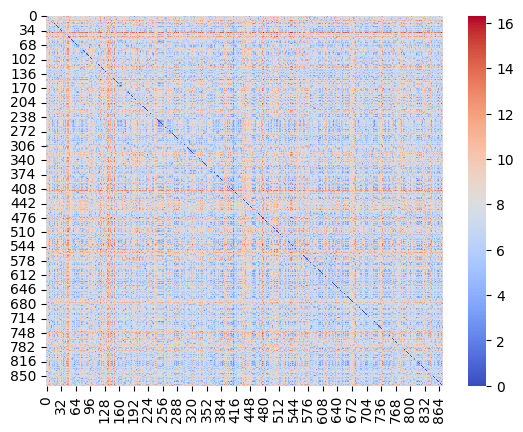

In [18]:
knowledge_linkage = best_linkage_method(preprocessed_dfs['Knowledge'], 5, 10)

Visualizing distance matrix to check clustering viability:

Summarizing results by metric:

  Method: ward
    • Best Silhouette: k=5, score=0.148 (higher=better)
    • Best Davies-Bouldin: k=8, score=1.607 (lower=better)
    • Best Calinski-Harabasz: k=5, score=252.144 (higher=better)

  Method: complete
    • Best Silhouette: k=10, score=0.124 (higher=better)
    • Best Davies-Bouldin: k=5, score=1.757 (lower=better)
    • Best Calinski-Harabasz: k=8, score=186.634 (higher=better)

  Method: average
    • Best Silhouette: k=6, score=0.186 (higher=better)
    • Best Davies-Bouldin: k=5, score=0.968 (lower=better)
    • Best Calinski-Harabasz: k=6, score=162.007 (higher=better)

  Method: single
    • Best Silhouette: k=5, score=-0.104 (higher=better)
    • Best Davies-Bouldin: k=10, score=0.650 (lower=better)
    • Best Calinski-Harabasz: k=9, score=2.883 (higher=better)


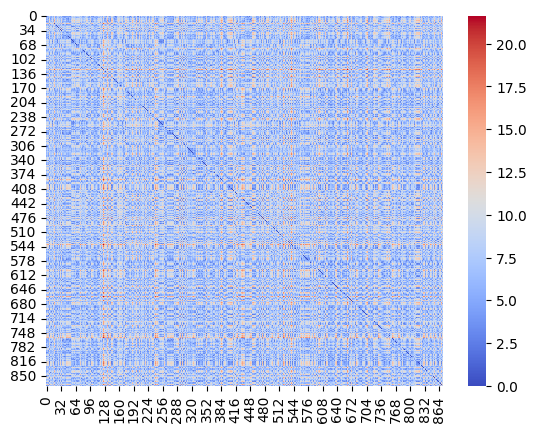

In [19]:
skill_linkage = best_linkage_method(preprocessed_dfs['Skill'], 5, 10)

Visualizing distance matrix to check clustering viability:

Summarizing results by metric:

  Method: ward
    • Best Silhouette: k=5, score=0.157 (higher=better)
    • Best Davies-Bouldin: k=6, score=1.780 (lower=better)
    • Best Calinski-Harabasz: k=5, score=239.980 (higher=better)

  Method: complete
    • Best Silhouette: k=6, score=0.200 (higher=better)
    • Best Davies-Bouldin: k=6, score=1.410 (lower=better)
    • Best Calinski-Harabasz: k=5, score=178.915 (higher=better)

  Method: average
    • Best Silhouette: k=6, score=0.276 (higher=better)
    • Best Davies-Bouldin: k=5, score=0.763 (lower=better)
    • Best Calinski-Harabasz: k=6, score=109.872 (higher=better)

  Method: single
    • Best Silhouette: k=5, score=0.232 (higher=better)
    • Best Davies-Bouldin: k=5, score=0.606 (lower=better)
    • Best Calinski-Harabasz: k=5, score=4.461 (higher=better)


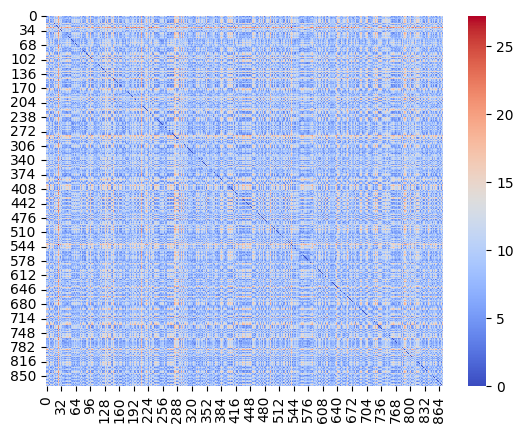

In [20]:
#activity_linkage = best_linkage_method(preprocessed_dfs['Work Activity'], 5, 10)
ability_linkage = best_linkage_method(preprocessed_dfs['Ability'], 5, 10)
#context_linkage = best_linkage_method(preprocessed_dfs['Work Context'], 5, 10)

## Bad News

Our idea to perform different linkage methods by using evaluation metrics sounds good theoretically but in practice it's struggling. As we can see from the results above, the scores are not great. This means that the data might not have a strong natural clustering structure or that hierarchical clustering might not be the best fit.

Upon further brainstorming, clustering may not be necessary if my end goal is to make a content-based filtering model. It's entirely possible to map user's inputs straight to the items in the dataset (user vector -> job vector/items). Then use something like cosine similarity to find the similarities between the user vector and job vector to give recommendations. Although clustering groups similar jobs/attributes together, this step isn't really required for delivering a top-N recommendations to a user. This could a simpler and more efficient approach but there will still be the caveat of designing quiz questions that line up well with the job vector and the PCA factors are semantically meaningful as well. So basically all the current issues that I'm facing anyways but not having to deal with hierarchical clustering.

I will save the current preprocessed df and use it in another notebook where I will start on the content-based filtering system.

In [21]:
# `preprocessed_dfs` is a mixture or multiple dataframes so I need to concat them all together first into one singular dataframe before saving as csv
df = pd.concat(preprocessed_dfs.values(), keys=preprocessed_dfs.keys())
df.head()

PC1       PC2       PC3       PC4  \
          Title                                                              
Knowledge Accountants and Auditors  0.150844 -1.677329 -3.569633 -1.439588   
          Actors                    3.150748 -3.826821 -1.083192  4.491928   
          Actuaries                -0.928525 -1.640804 -2.083088  0.266277   
          Acupuncturists            4.235910 -1.900022  1.678363 -1.771601   
          Acute Care Nurses         4.288213 -1.057318  4.038716 -1.231619   

                                         PC5       PC6       PC7       PC8  \
          Title                                                              
Knowledge Accountants and Auditors -2.775247 -0.688476  2.091873 -1.999936   
          Actors                    1.502716  3.698599 -1.631303  0.511189   
          Actuaries                -3.383021 -0.504823  2.343000 -1.833827   
          Acupuncturists           -0.130812  1.941703 -0.596128  0.127749   
          Acute Care Nurses        -0.455527  0.266977 -0.708505 -0.217192   

                                         PC9      PC10  ...  PC23  PC24  PC25  \
          Title                                         ...                     
Knowledge Accountants and Auditors -0.105774 -0.369862  ...   NaN   NaN   NaN   
          Actors                   -1.195583 -1.252292  ...   NaN   NaN   NaN   
          Actuaries                 0.004706  0.468745  ...   NaN   NaN   NaN   
          Acupuncturists           -1.277658  0.282480  ...   NaN   NaN   NaN   
          Acute Care Nurses        -0.290552  1.226277  ...   NaN   NaN   NaN   

                                    PC26  PC27  PC28  PC29  PC30  PC31  PC32  
          Title                                                               
Knowledge Accountants and Auditors   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
          Actors                     NaN   NaN   NaN   NaN   NaN   NaN   NaN  
          Actuaries                  NaN   NaN   NaN   NaN   NaN   NaN   NaN  
          Acupuncturists             NaN   NaN   NaN   NaN   NaN   NaN   NaN  
          Acute Care Nurses          NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 32 columns]

In [25]:
# Well it seems that since the dimension sizes are different for each attribute, combining them all together is not a good idea because we are a lot of NaNs for certain attributes with less dimension.
# We are going to have to convert each attribute into different CSVs and use that for our model building.


In [29]:
final_df = preprocessed_dfs['Knowledge'].merge(preprocessed_dfs['Skill'], how='outer') \
                                   .merge(preprocessed_dfs['Ability'], how='outer') \
                                   .merge(preprocessed_dfs['Work Context'], how='outer') \
                                   .merge(preprocessed_dfs['Work Activity'], how='outer')
final_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32
0,-12.830377,-6.605722,3.290682,-2.192661,-0.110204,0.477899,1.864071,0.715984,0.839178,0.060620,...,-0.074703,0.577474,0.244539,0.359447,NaN,NaN,NaN,NaN,NaN,NaN
1,-12.453447,-1.527859,1.513633,0.341792,0.659941,-2.125136,-0.208269,1.033665,-0.751788,0.657285,...,-0.139002,-0.371811,-0.210800,-0.097329,NaN,NaN,NaN,NaN,NaN,NaN
2,-11.456660,0.824008,0.438391,0.238040,0.367570,0.546165,-2.591667,0.264374,0.638313,-0.043989,...,0.442864,0.216159,-1.063680,-0.108079,NaN,NaN,NaN,NaN,NaN,NaN
3,-10.814557,-3.721825,1.943128,1.129217,-1.471620,-0.397121,-0.396027,0.037766,-1.463367,1.744546,...,0.343793,-0.099661,-0.468755,-1.081101,NaN,NaN,NaN,NaN,NaN,NaN
4,-10.137788,-1.947761,1.501401,1.867426,-0.226052,-0.462802,0.731225,-0.098698,0.779695,-0.082811,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
